In [ ]:
#!unzip "/content/drive/MyDrive/dog-vision/dog-breed-identification.zip" -d "drive/MyDrive/dog-vision/"

# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using Tensorflow.

## 1. Problem

Identifying the breed of a dog given its image.

## 2. Data

The data I'm using is from Kaggle: https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each image.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information:
* Images -> best to use deep learning
* There are 120 breeds of dogs -> 120 classes
* 10 000+ images in the training set (with labels)
* 10 000+ images in the test set (no labels->labels need to be predicted)

## Get workspace ready

In [2]:
# Import TensorFlow into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:",tf.__version__)
print("TF Hub version:",hub.__version__)

# Check for GPU
print("GPU","available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.5.0
TF Hub version: 0.12.0
GPU available


## Getting data ready (turning into Tensors)

All our data has to be in numerical. Therefore, we shall turn images into Tensors

In [3]:
import pandas as pd
labels_csv=pd.read_csv("/content/drive/MyDrive/dog-vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     96e7a7493dcf1bbcdc6be986fc04a71c  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


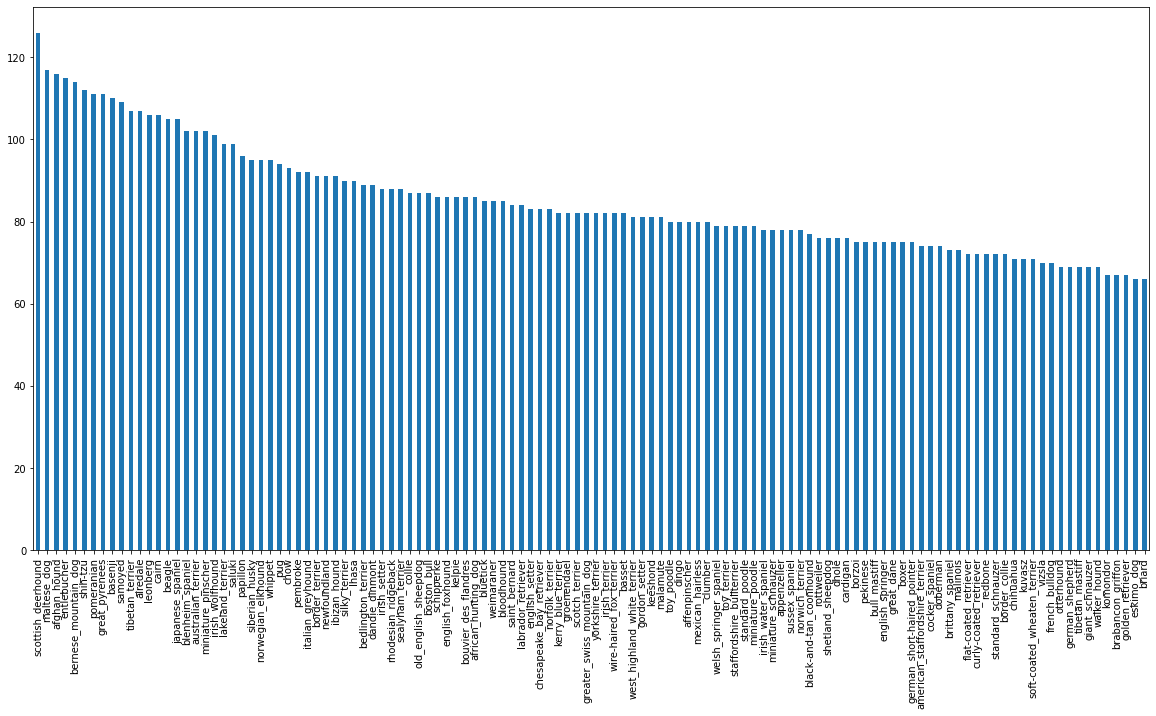

In [4]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

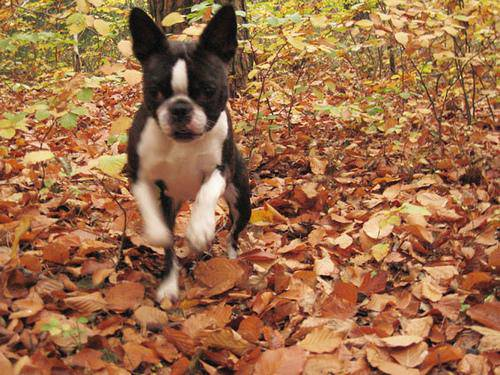

In [5]:
from IPython.display import Image
Image("/content/drive/MyDrive/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")


## Getting images and their labels

In [6]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
filenames=["drive/MyDrive/dog-vision/train/"+fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/MyDrive/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/dog-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/dog-vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/dog-vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/dog-vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/dog-vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/dog-vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [8]:

# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/dog-vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


## Time to convert images to numbers

In [9]:
import numpy as np
labels=labels_csv["breed"].to_numpy()
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [10]:
unique_breeds=np.unique(labels)
len(unique_breeds)

120

In [11]:
boolean_labels=[label==np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

## Creating validation set

In [12]:
X = filenames
y = boolean_labels
# experimenting with 1000 images
NUM_IMAGES=1000


In [13]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val=train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.2,random_state=0)

len(X_train),len(y_train),len(X_val),len(y_val)

(800, 800, 200, 200)

In [14]:
X_train[:5],y_train[:2]

(['drive/MyDrive/dog-vision/train/10ce268c0affd428a49ada5a79fe9ca8.jpg',
  'drive/MyDrive/dog-vision/train/0c0fb87fb13f0f6c8d21ff6c15e3361e.jpg',
  'drive/MyDrive/dog-vision/train/080073330bb8954505340cf18159fbb8.jpg',
  'drive/MyDrive/dog-vision/train/181e91cb6caf6739478d06231faa053d.jpg',
  'drive/MyDrive/dog-vision/train/141706c74486585c27de2dfb335695bb.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## Time to turn these images into Tensors

* Take image filename as input
* Use TensorFlow to read the file and save it to a variable
* Turn image into Tensor
* Resize the image to be of shape (224,224)
* Return the modified image

In [15]:
from matplotlib.pyplot import imread
image=imread(filenames[42])
image.shape

(257, 350, 3)

In [16]:
# Convert image into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [17]:
# Define image size
IMG_SIZE=224

def process_image(image_path):
  # Read image file
  image=tf.io.read_file(image_path)
  # Turn the jpeg image into Tensor with 3 colour channels (Red,Green,Blue)
  image=tf.image.decode_jpeg(image,channels=3)
  # Convert the colour channel values from 0-225 to 0-1
  image=tf.image.convert_image_dtype(image,tf.float32)
  # Resize image
  image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])
  return image

## Creating data batches

Time to make BatchDatasets.

A batch is a small portion of our data. In deep learning, instead of finding patters in an entire dataset at once, we find them in one batch at a time, because trying to compute over 10 000 images at once takes up more memory than a typical GPU has.

In [18]:
# Create function to return a tuple (image,label)
def get_image_label(image_path,label):
  image=process_image(image_path)
  return image,label

According to Yann Lecun, batch sizes should be 32.

In [19]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [20]:
train_data=create_data_batches(X_train,y_train)
val_data=create_data_batches(X_val,y_val,valid_data=True)

Creating training data batches...
Creating validation data batches...


In [21]:
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing data branches

In [22]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images,labels):
  plt.figure(figsize=(10,10))
  for i in range(25):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

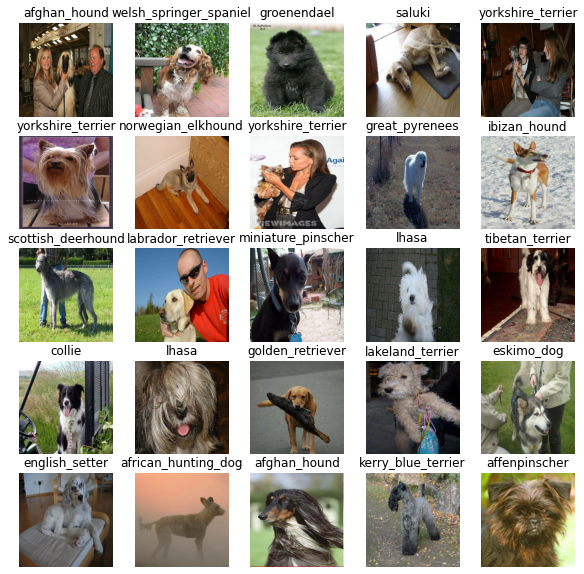

In [23]:
train_images,train_labels=next(train_data.as_numpy_iterator())
show_25_images(train_images,train_labels)

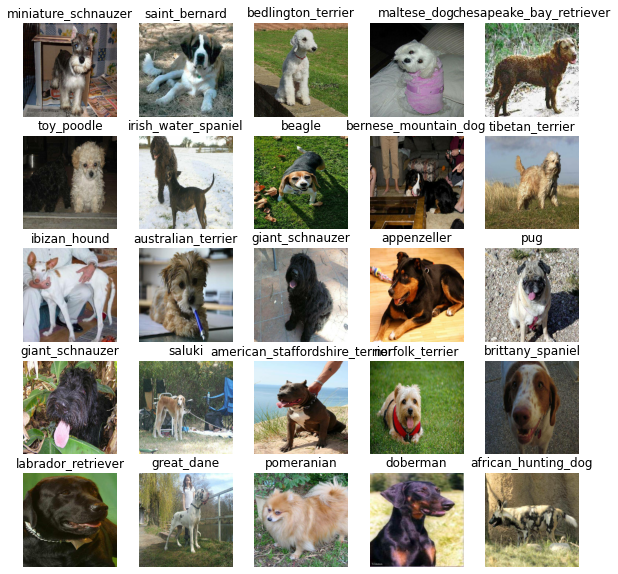

In [24]:
val_images,val_labels=next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

## Time to create and train a model

I will be using an existing model from TensorFlow Hub.

Using a pretrained model is called transfer learning.

In [25]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [26]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

In [27]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [28]:

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [29]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)